In [150]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

In [151]:
# Load data
constructor_standings_path = 'constructorstandings.csv'
race_results_path = 'raceresults.csv'
qualifying_results_path = 'qualifyingresults.csv'
pit_stops_path = 'pitstops.csv'


In [152]:
constructor_standings_df = pd.read_csv(constructor_standings_path)
race_results_df = pd.read_csv(race_results_path)
qualifying_results_df = pd.read_csv(qualifying_results_path)
pitstops_df = pd.read_csv(pit_stops_path)

In [153]:
pitstops_df['duration'] = pd.to_numeric(pitstops_df['duration'], errors='coerce')

In [154]:
# Clean data
constructor_standings_df.drop(columns='Unnamed: 0', inplace=True)
pitstops_df.drop(columns='Unnamed: 0', inplace=True)
qualifying_results_df.drop(columns='Unnamed: 0', inplace=True)
race_results_df.drop(columns='Unnamed: 0', inplace=True)

In [155]:
# Merge datasets
enhanced_constructor_data = pd.merge(constructor_standings_df, race_results_df,
                                     on=['season', 'constructor_id', 'round'], suffixes=('_stand', '_race'))
enhanced_constructor_data = pd.merge(enhanced_constructor_data, qualifying_results_df,
                                     on=['season', 'constructor_id', 'round', 'driver_id'], suffixes=('', '_qual'))
enhanced_constructor_data = pd.merge(enhanced_constructor_data, pitstops_df,
                                     on=['season', 'driver_id', 'round'], how='left', suffixes=('', '_pit'))

# Drop duplicates
enhanced_constructor_data.drop_duplicates(inplace=True)

In [156]:
#| label: merged-data
enhanced_constructor_data.head()

,season,round,constructor_id,position_stand,points_stand,wins,race_name,position_race,driver_id,laps,time,points_race,race_name_qual,position,q1,q2,q3,race_name_pit,stop,lap,time_pit,duration
0,2023,1,red_bull,1,43.0,1,Bahrain Grand Prix,1.0,max_verstappen,57.0,1:33:56.736,25.0,Bahrain Grand Prix,1.0,1:31.295,1:30.503,1:29.708,Bahrain Grand Prix,1.0,14.0,18:26:35,24.289
4,2023,1,red_bull,1,43.0,1,Bahrain Grand Prix,2.0,perez,57.0,+11.987,18.0,Bahrain Grand Prix,2.0,1:31.479,1:30.746,1:29.846,Bahrain Grand Prix,1.0,17.0,18:31:42,24.264
48,2023,1,aston_martin,2,23.0,0,Bahrain Grand Prix,3.0,alonso,57.0,+38.637,15.0,Bahrain Grand Prix,5.0,1:31.158,1:30.645,1:30.336,Bahrain Grand Prix,1.0,14.0,18:27:02,25.800
52,2023,1,aston_martin,2,23.0,0,Bahrain Grand Prix,6.0,stroll,57.0,+54.502,8.0,Bahrain Grand Prix,8.0,1:31.184,1:31.127,1:30.836,Bahrain Grand Prix,1.0,15.0,18:28:45,25.449
96,2023,1,mercedes,3,16.0,0,Bahrain Grand Prix,5.0,hamilton,57.0,+50.977,10.0,Bahrain Grand Prix,7.0,1:31.543,1:30.513,1:30.384,Bahrain Grand Prix,1.0,12.0,18:23:40,24.682


In [157]:
# Create new features
enhanced_constructor_data['qualifying_race_position_delta'] = enhanced_constructor_data['position'] - enhanced_constructor_data['position_race']
enhanced_constructor_data['average_qualifying_position'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['position'].transform('mean')
enhanced_constructor_data['std_position_delta'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['qualifying_race_position_delta'].transform('std')

# Filter data for specific constructors and seasons from 2012 onwards
filtered_constructors = ['ferrari', 'red_bull', 'mercedes']
recent_data = enhanced_constructor_data[
    (enhanced_constructor_data['constructor_id'].isin(filtered_constructors)) & 
    (enhanced_constructor_data['season'] >= 2012)
]

In [158]:
# Calculate performance metrics
performance_metrics = recent_data.groupby(['season', 'constructor_id']).agg(
    average_finishing_position=pd.NamedAgg(column='position_race', aggfunc='mean'),
    total_points=pd.NamedAgg(column='points_stand', aggfunc='sum'),
    podium_finishes=pd.NamedAgg(column='position_race', aggfunc=lambda x: (x <= 3).sum()),
    average_pit_stop_duration=pd.NamedAgg(column='duration', aggfunc='mean'),
    average_pit_stop_count=pd.NamedAgg(column='stop', aggfunc='count'),
    mean_qualifying_position=pd.NamedAgg(column='average_qualifying_position', aggfunc='mean'),
    mean_position_delta=pd.NamedAgg(column='qualifying_race_position_delta', aggfunc='mean'),
    std_position_delta=pd.NamedAgg(column='std_position_delta', aggfunc='mean')
).reset_index()


In [159]:
recent_data.head()

,season,round,constructor_id,position_stand,points_stand,wins,race_name,position_race,driver_id,laps,time,points_race,race_name_qual,position,q1,q2,q3,race_name_pit,stop,lap,time_pit,duration,qualifying_race_position_delta,average_qualifying_position,std_position_delta
0,2023,1,red_bull,1,43.0,1,Bahrain Grand Prix,1.0,max_verstappen,57.0,1:33:56.736,25.0,Bahrain Grand Prix,1.0,1:31.295,1:30.503,1:29.708,Bahrain Grand Prix,1.0,14.0,18:26:35,24.289,0.0,6.774194,6.045395
4,2023,1,red_bull,1,43.0,1,Bahrain Grand Prix,2.0,perez,57.0,+11.987,18.0,Bahrain Grand Prix,2.0,1:31.479,1:30.746,1:29.846,Bahrain Grand Prix,1.0,17.0,18:31:42,24.264,0.0,6.774194,6.045395
96,2023,1,mercedes,3,16.0,0,Bahrain Grand Prix,5.0,hamilton,57.0,+50.977,10.0,Bahrain Grand Prix,7.0,1:31.543,1:30.513,1:30.384,Bahrain Grand Prix,1.0,12.0,18:23:40,24.682,2.0,6.353846,6.598842
97,2023,1,mercedes,3,16.0,0,Bahrain Grand Prix,5.0,hamilton,57.0,+50.977,10.0,Bahrain Grand Prix,7.0,1:31.543,1:30.513,1:30.384,Bahrain Grand Prix,2.0,30.0,18:53:36,24.690,2.0,6.353846,6.598842
104,2023,1,mercedes,3,16.0,0,Bahrain Grand Prix,7.0,russell,57.0,+55.873,6.0,Bahrain Grand Prix,6.0,1:31.057,1:30.507,1:30.340,Bahrain Grand Prix,1.0,13.0,18:25:24,27.062,-1.0,6.353846,6.598842


In [160]:

performance_metrics = recent_data.groupby(['season', 'constructor_id']).agg(
    average_finishing_position=pd.NamedAgg(column='position_race', aggfunc='mean'),
    total_points=pd.NamedAgg(column='points_stand', aggfunc='sum'),
    podium_finishes=pd.NamedAgg(column='position_race', aggfunc=lambda x: (x <= 3).sum()),
    average_pit_stop_duration=pd.NamedAgg(column='duration', aggfunc='mean'),
    average_pit_stop_count=pd.NamedAgg(column='stop', aggfunc='count'),
    mean_qualifying_position=pd.NamedAgg(column='average_qualifying_position', aggfunc='mean'),
    mean_position_delta=pd.NamedAgg(column='qualifying_race_position_delta', aggfunc='mean'),
    std_position_delta=pd.NamedAgg(column='std_position_delta', aggfunc='mean')
).reset_index()

In [161]:
#| label: performance-metrics
performance_metrics.head()

,season,constructor_id,average_finishing_position,total_points,podium_finishes,average_pit_stop_duration,average_pit_stop_count,mean_qualifying_position,mean_position_delta,std_position_delta
0,2012,ferrari,7.142857,8918.0,17,22.135404,47,8.816327,1.673469,5.125052
1,2012,mercedes,12.631579,5321.0,3,22.318074,54,9.456140,-3.175439,7.171677
2,2012,red_bull,6.580000,12536.0,17,22.060939,49,4.880000,-1.700000,6.728708
3,2013,ferrari,6.633333,11605.0,16,22.958483,58,7.183333,0.550000,5.013287
4,2013,mercedes,7.054545,10909.0,13,23.113691,55,3.781818,-3.272727,5.254467


In [162]:
# Define color codes for teams
team_colors = {
    'ferrari': '#dc0000',
    'mercedes': '#00d2be',
    'red_bull': '#fcd700'
}

In [163]:
# # Prepare features and target for modeling
# X = performance_metrics[['average_finishing_position', 'podium_finishes', 'average_pit_stop_count','average_pit_stop_duration',
#                          'mean_qualifying_position', 'mean_position_delta', 'std_position_delta']]
# y = performance_metrics['total_points']

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize and train the Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = model.predict(X_test)

# # Calculate Mean Squared Error
# mse = mean_squared_error(y_test, y_pred)

In [164]:
# # Visualize data and results
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# # Average Finishing Position
# for key, grp in performance_metrics.groupby('constructor_id'):
#     axes[0].plot(grp['season'], grp['average_finishing_position'], marker='o', label=key.capitalize(), color=team_colors[key])
# axes[0].set_title('Average Finishing Position Per Season')
# axes[0].set_xlabel('Season')
# axes[0].set_ylabel('Average Position')
# axes[0].invert_yaxis()
# axes[0].legend()
# axes[0].grid(True)

# # Total Points Per Season
# for key, grp in performance_metrics.groupby('constructor_id'):
#     axes[1].plot(grp['season'], grp['total_points'], marker='o', label=key.capitalize(), color=team_colors[key])
# axes[1].set_title('Total Points Per Season')
# axes[1].set_xlabel('Season')
# axes[1].set_ylabel('Total Points')
# axes[1].legend()
# axes[1].grid(True)

# # Podium Finishes
# for key, grp in performance_metrics.groupby('constructor_id'):
#     axes[2].bar(grp['season'], grp['podium_finishes'], label=key.capitalize(), color=team_colors[key])
# axes[2].set_title('Podium Finishes Per Season')
# axes[2].set_xlabel('Season')
# axes[2].set_ylabel('Podium Finishes')
# axes[2].legend()
# axes[2].grid(True)

# plt.tight_layout()
# plt.show()

# print("Model Mean Squared Error:", mse)

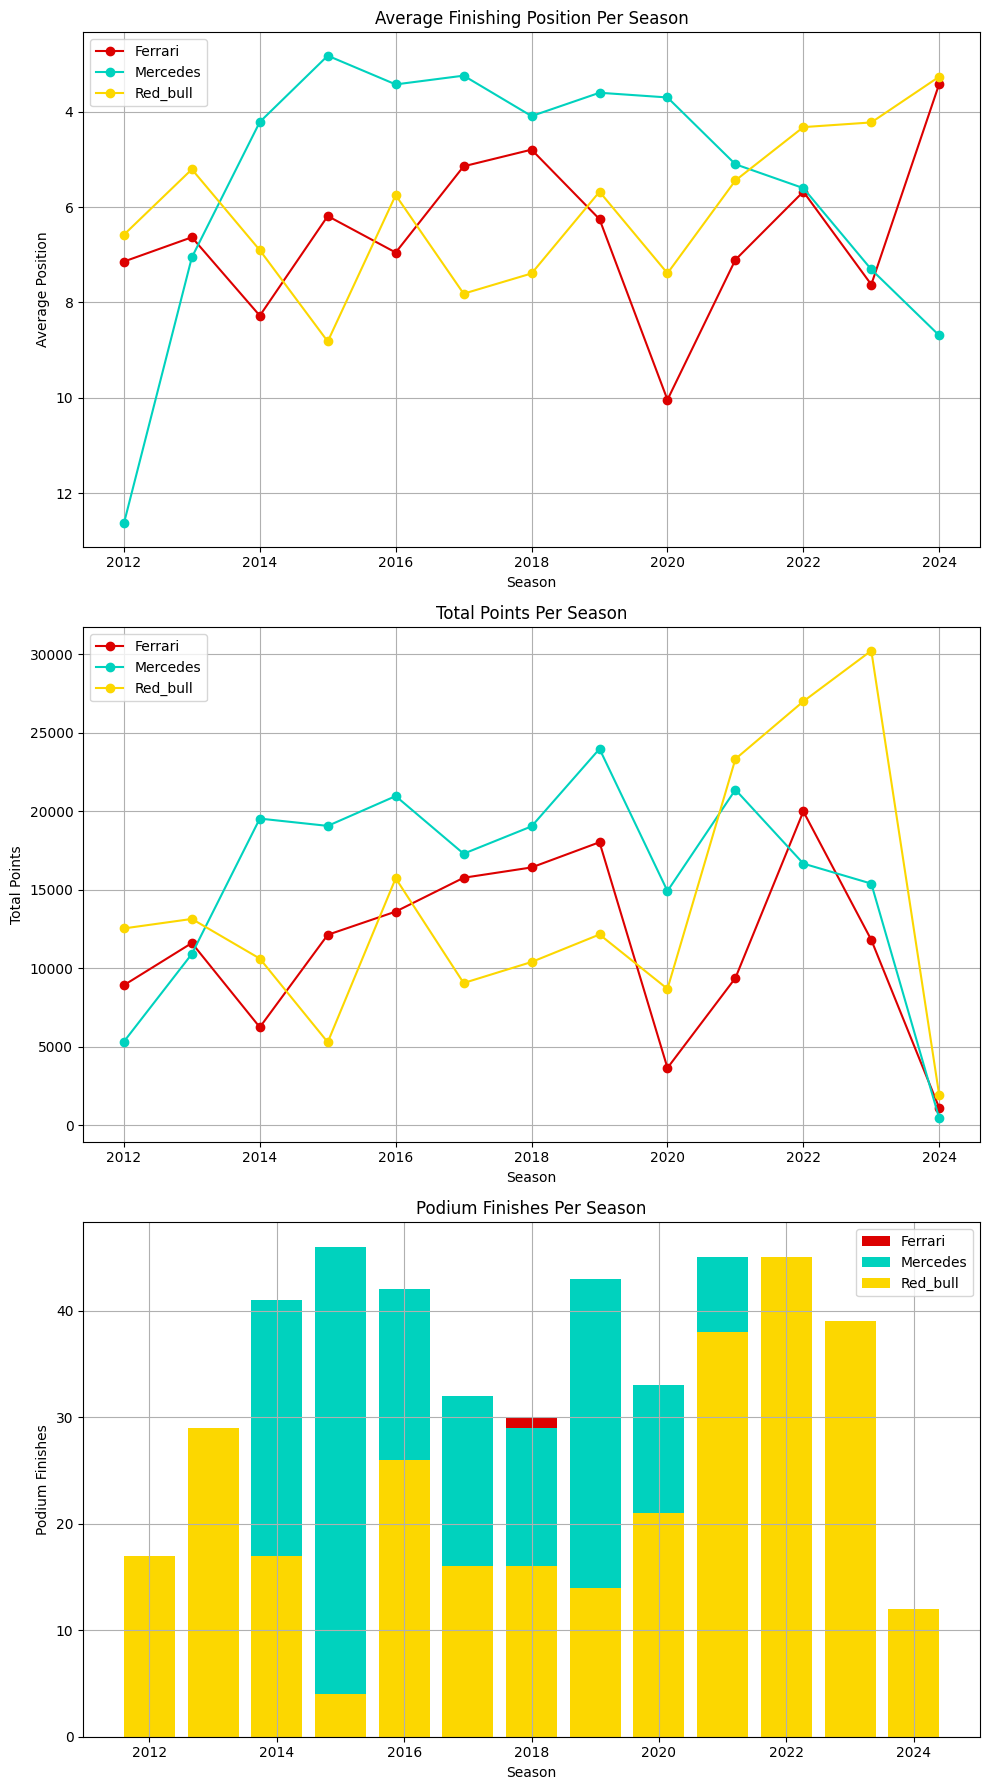

Model Mean Squared Error: 0.48031115413974756


In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load data
constructor_standings_df = pd.read_csv('constructorstandings.csv')
race_results_df = pd.read_csv('raceresults.csv')
qualifying_results_df = pd.read_csv('qualifyingresults.csv')
pitstops_df = pd.read_csv('pitstops.csv')

# Drop unnecessary 'Unnamed: 0' columns if present
datasets = [constructor_standings_df, race_results_df, qualifying_results_df, pitstops_df]
for dataset in datasets:
    if 'Unnamed: 0' in dataset.columns:
        dataset.drop(columns='Unnamed: 0', inplace=True)

# Convert 'duration' column in pitstops_df to numeric, ignoring errors
pitstops_df['duration'] = pd.to_numeric(pitstops_df['duration'], errors='coerce')

# Merging the dataframes
enhanced_constructor_data = pd.merge(constructor_standings_df, race_results_df,
                                     on=['season', 'constructor_id', 'round'], suffixes=('_stand', '_race'))
enhanced_constructor_data = pd.merge(enhanced_constructor_data, qualifying_results_df,
                                     on=['season', 'constructor_id', 'round', 'driver_id'], suffixes=('', '_qual'))
enhanced_constructor_data = pd.merge(enhanced_constructor_data, pitstops_df,
                                     on=['season', 'driver_id', 'round'], how='left', suffixes=('', '_pit'))

# Drop duplicates
enhanced_constructor_data.drop_duplicates(inplace=True)

# Calculate additional performance metrics
enhanced_constructor_data['total_points'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['points_race'].transform('sum')
enhanced_constructor_data['podium_finishes'] = enhanced_constructor_data[enhanced_constructor_data['position_race'] <= 3].groupby(['season', 'constructor_id'])['position_race'].transform('count')
enhanced_constructor_data['average_finishing_position'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['position_race'].transform('mean')
enhanced_constructor_data['average_pit_stop_duration'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['duration'].transform('mean')
enhanced_constructor_data['average_pit_stop_count'] = enhanced_constructor_data.groupby(['season', 'constructor_id'])['stop'].transform('size')

# Prepare data for modeling
X = enhanced_constructor_data[['average_finishing_position', 'podium_finishes', 'average_pit_stop_count', 'average_pit_stop_duration']]
y = enhanced_constructor_data['total_points']


from sklearn.impute import SimpleImputer

# Imputing missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

mse


# Visualize data and results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Average Finishing Position
for key, grp in performance_metrics.groupby('constructor_id'):
    axes[0].plot(grp['season'], grp['average_finishing_position'], marker='o', label=key.capitalize(), color=team_colors[key])
axes[0].set_title('Average Finishing Position Per Season')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Average Position')
axes[0].invert_yaxis()
axes[0].legend()
axes[0].grid(True)

# Total Points Per Season
for key, grp in performance_metrics.groupby('constructor_id'):
    axes[1].plot(grp['season'], grp['total_points'], marker='o', label=key.capitalize(), color=team_colors[key])
axes[1].set_title('Total Points Per Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Total Points')
axes[1].legend()
axes[1].grid(True)

# Podium Finishes
for key, grp in performance_metrics.groupby('constructor_id'):
    axes[2].bar(grp['season'], grp['podium_finishes'], label=key.capitalize(), color=team_colors[key])
axes[2].set_title('Podium Finishes Per Season')
axes[2].set_xlabel('Season')
axes[2].set_ylabel('Podium Finishes')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print("Model Mean Squared Error:", mse)

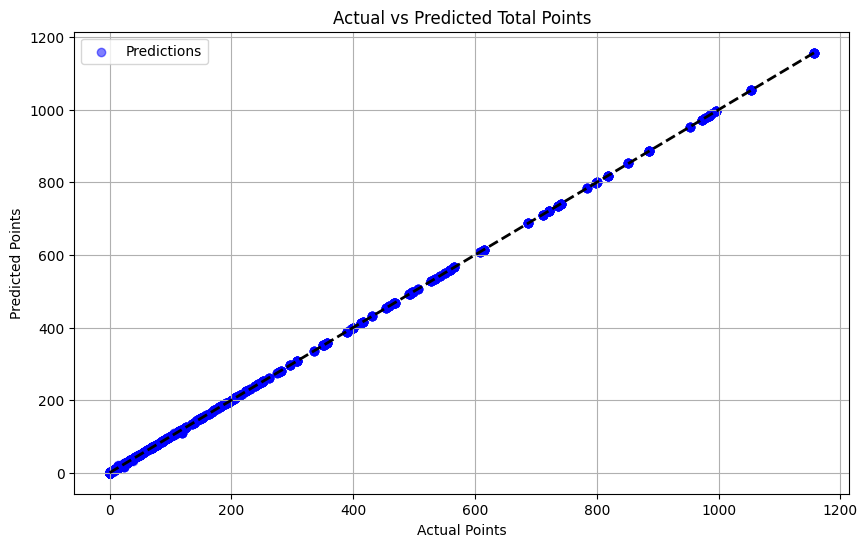

In [166]:
#| label: prediction-actual

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions', alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Total Points')
plt.legend()
plt.grid(True)
plt.show()


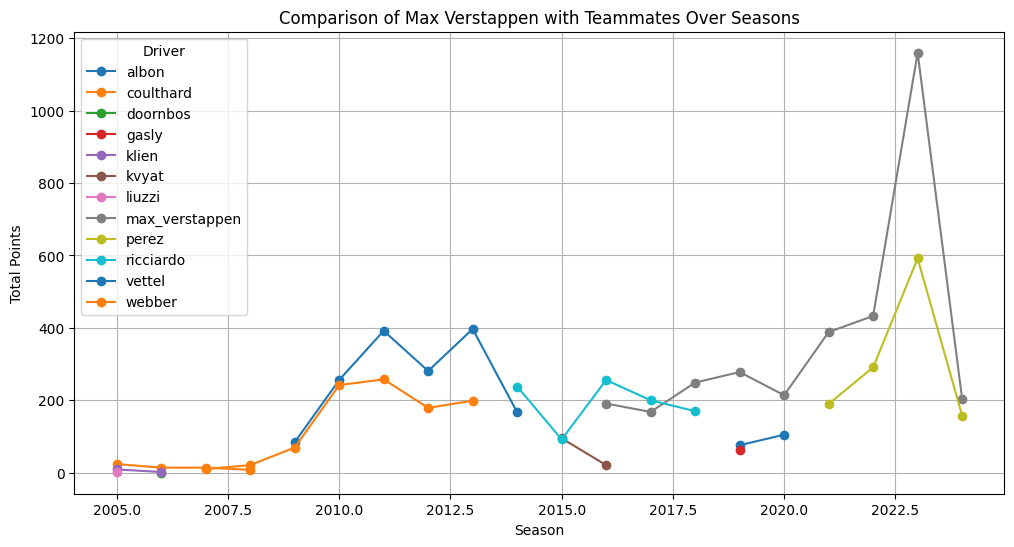

In [167]:
#| label: max-points
import matplotlib.pyplot as plt
import pandas as pd

# Example setup: Load your data frames (this part should be adjusted based on your actual data loading setup)
# race_results_df = pd.read_csv('raceresults.csv')

# Filter data for Max Verstappen and his team (assuming Red Bull and his driver_id is 'max_verstappen')
verstappen_team_filter = race_results_df['constructor_id'] == 'red_bull'
team_data = race_results_df[verstappen_team_filter]

# Group by season and driver to calculate total points
driver_points_per_season = team_data.groupby(['season', 'driver_id'])['points'].sum().unstack()

# Plotting
plt.figure(figsize=(12, 6))
for driver in driver_points_per_season.columns:
    plt.plot(driver_points_per_season.index, driver_points_per_season[driver], marker='o', label=driver)
plt.title('Comparison of Max Verstappen with Teammates Over Seasons')
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.legend(title='Driver')
plt.grid(True)
plt.show()


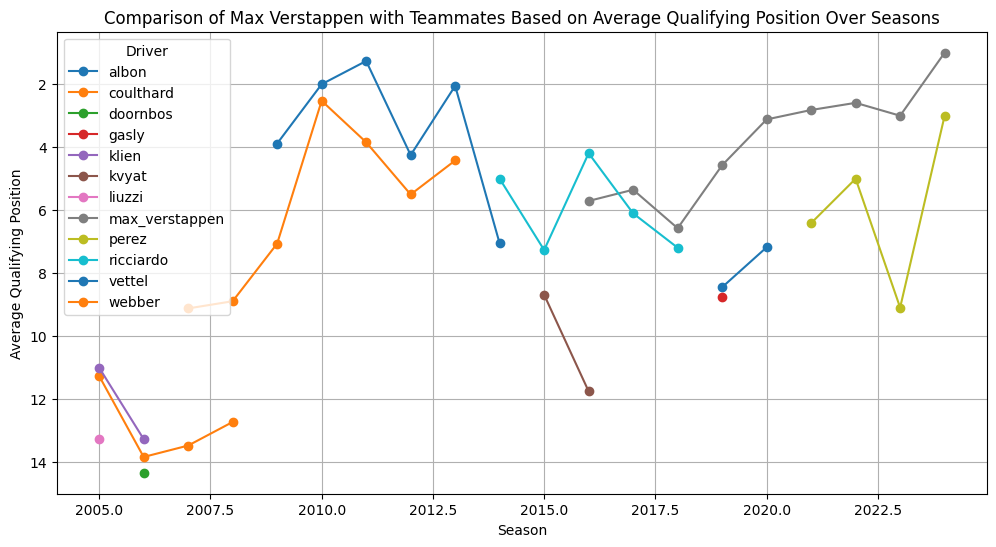

In [168]:
#| label: max-quali
import matplotlib.pyplot as plt
import pandas as pd

# Assuming qualifying_results_df is already loaded with relevant data
# Filter data for Max Verstappen and his team (assuming Red Bull and an example driver_id like 'max_verstappen')
verstappen_team_filter = qualifying_results_df['constructor_id'] == 'red_bull'
team_data = qualifying_results_df[verstappen_team_filter]

# Group by season and driver to calculate average qualifying positions
driver_qualifying_per_season = team_data.groupby(['season', 'driver_id'])['position'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 6))
for driver in driver_qualifying_per_season.columns:
    plt.plot(driver_qualifying_per_season.index, driver_qualifying_per_season[driver], marker='o', label=driver)
plt.title('Comparison of Max Verstappen with Teammates Based on Average Qualifying Position Over Seasons')
plt.xlabel('Season')
plt.ylabel('Average Qualifying Position')
plt.legend(title='Driver')
plt.gca().invert_yaxis()  # Invert y-axis to show the best qualifying positions (lowest numbers) at the top
plt.grid(True)
plt.show()


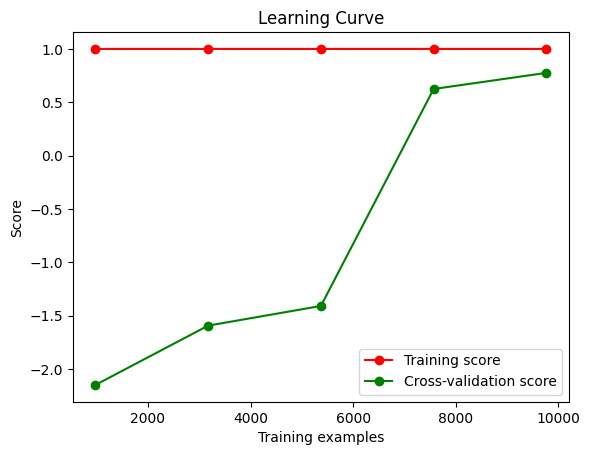

In [169]:
#| label: learning-curve

import numpy as np
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X_imputed, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()


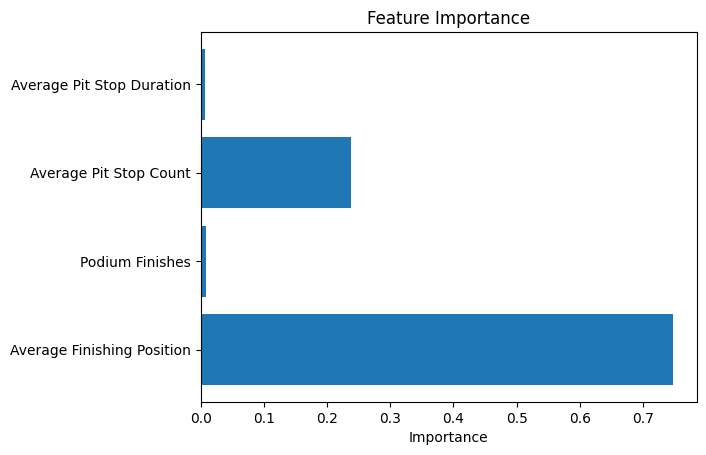

In [170]:
importances = model.feature_importances_
features = ['Average Finishing Position', 'Podium Finishes', 'Average Pit Stop Count', 'Average Pit Stop Duration']
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


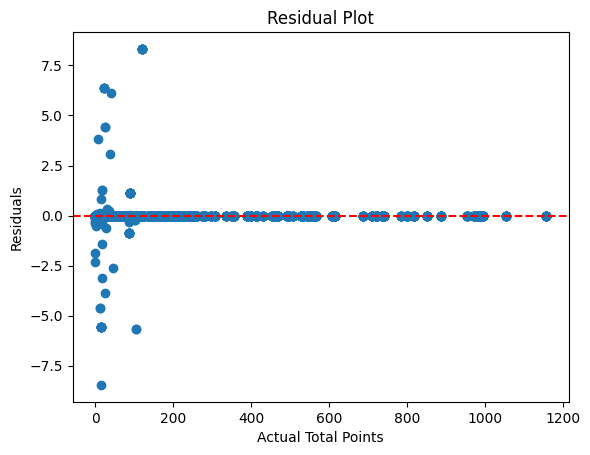

In [171]:
#| label: residual-plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual Total Points')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.show()

In [172]:
#| label: metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.48031115413974756
R-squared: 0.9999933590979309
